# Modeling for Diamond Data Set

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import joblib


In [20]:
df = pd.read_csv("diamonds.csv")

## Checking the data

In [21]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [22]:
df.shape

(53940, 10)

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [24]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Data Preprocessing

In [25]:
# We should delete rows where x, y, z are 0.
df = df.drop(df[df["x"]==0].index)
df = df.drop(df[df["y"]==0].index)
df = df.drop(df[df["y"]==0].index)

In [8]:
df.shape

(53932, 10)

From 53940 to 53932 ==> 8 faulty rows removed

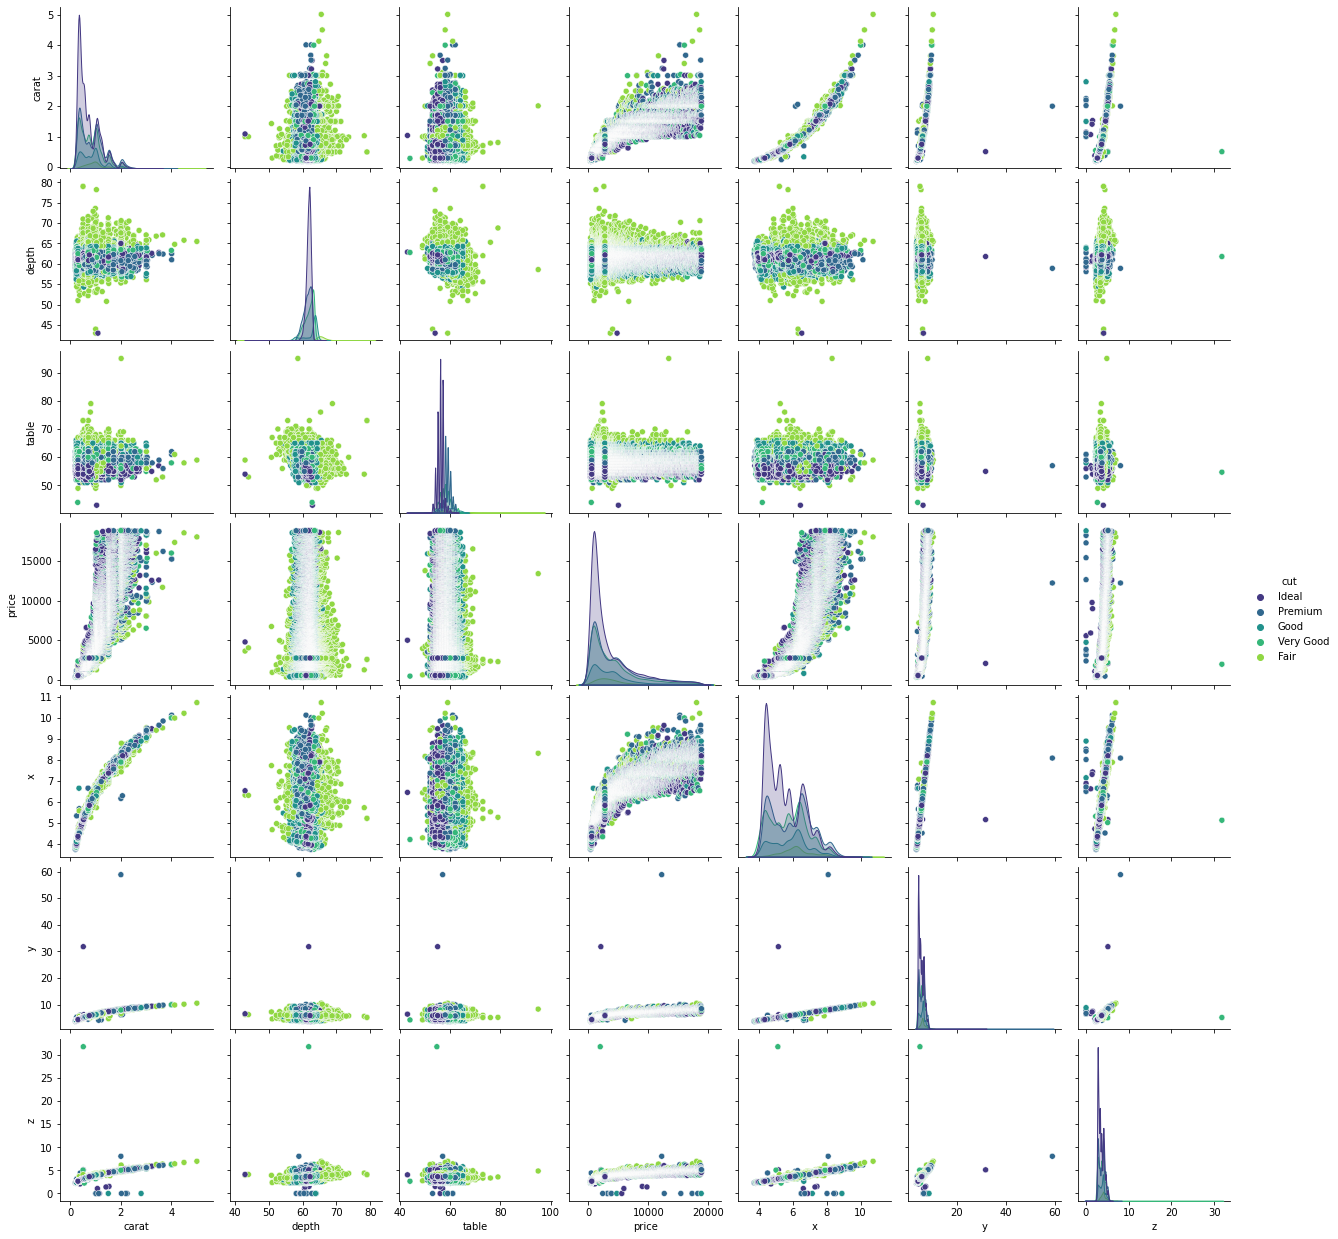

In [9]:
sns.pairplot(data=df, hue="cut", palette="viridis")

## There are outliers we need to remove.

In [33]:
df = df.drop(df[(df["carat"]<2) & (df["z"]>20)].index)

In [40]:
df = df.drop(df[(df["carat"]>0) & (df["y"]>20)].index)

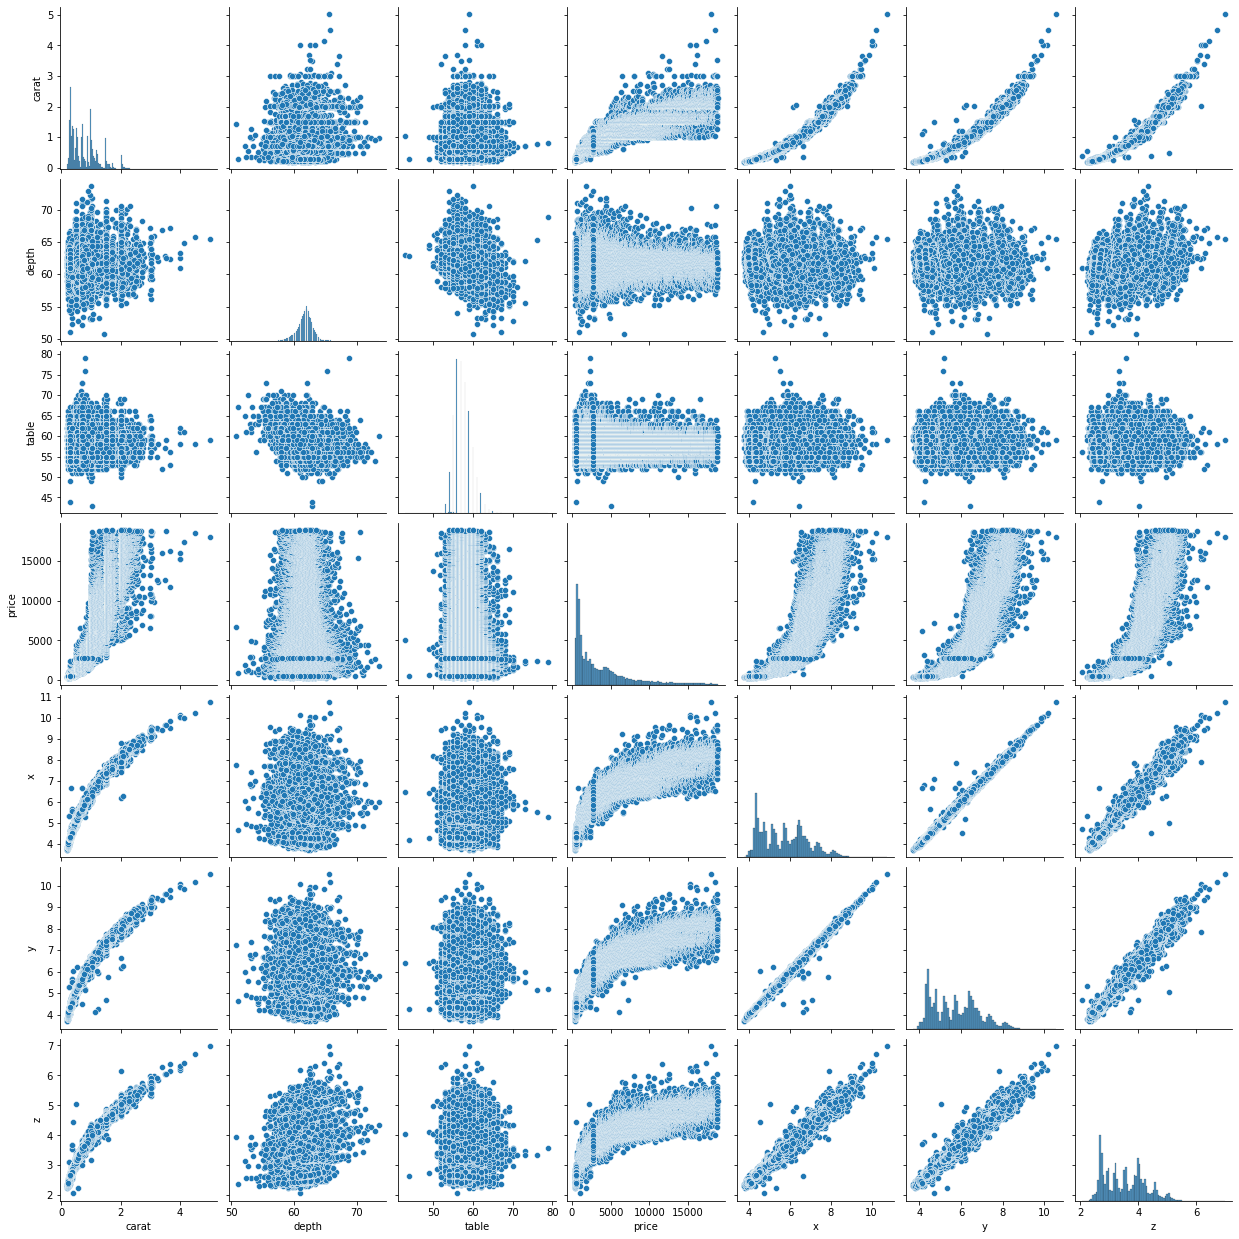

In [66]:
sns.pairplot(df)

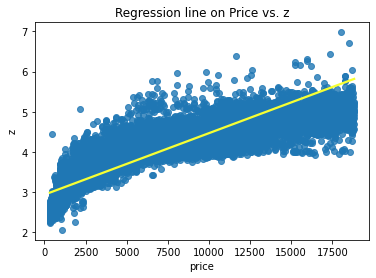

In [77]:
sns.regplot(x="price", y="z", data=df, fit_reg=True, line_kws={"color":"#F6FF33"})
plt.title("Regression line on Price vs. z")
plt.show()

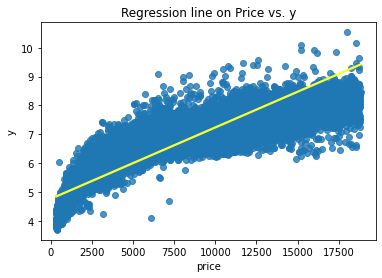

In [76]:
sns.regplot(x="price", y="y", data=df, fit_reg=True, line_kws={"color":"#F6FF33"})
plt.title("Regression line on Price vs. y")
plt.show()

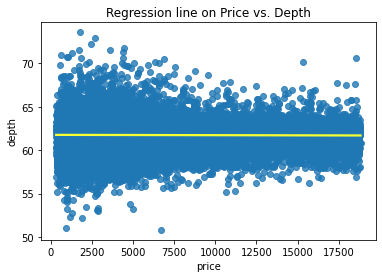

In [75]:
sns.regplot(x="price", y="depth", data=df, fit_reg=True, line_kws={"color":"#F6FF33"})
plt.title("Regression line on Price vs. Depth")
plt.show()

## Dealing with categorical variables

In [98]:
df_objs = (df.dtypes == "object")
object_col = list(df_objs[df_objs].index)
object_col

['cut', 'color', 'clarity']

In [101]:
df[["cut", "color", "clarity"]]

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2
...,...,...,...
53935,Ideal,D,SI1
53936,Good,D,SI1
53937,Very Good,D,SI1
53938,Premium,H,SI2


Text(0, 0.5, 'Cut')

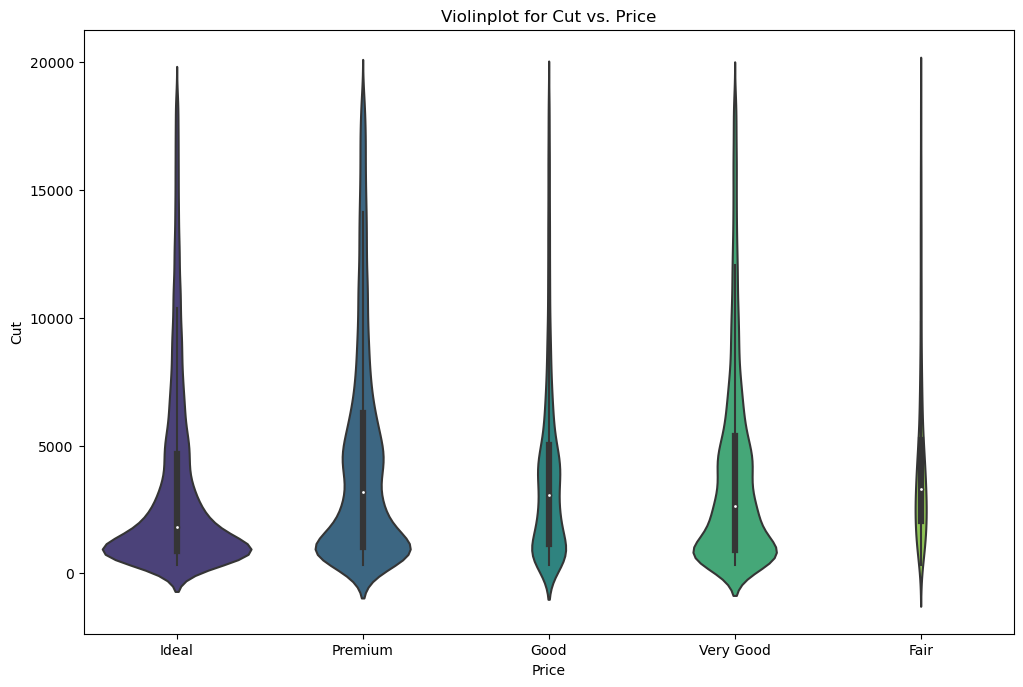

In [102]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(x="cut", y="price", data=df, palette="viridis", scale="count")
plt.title("Violinplot for Cut vs. Price")
plt.xlabel("Price")
plt.ylabel("Cut")

Text(0, 0.5, 'Color')

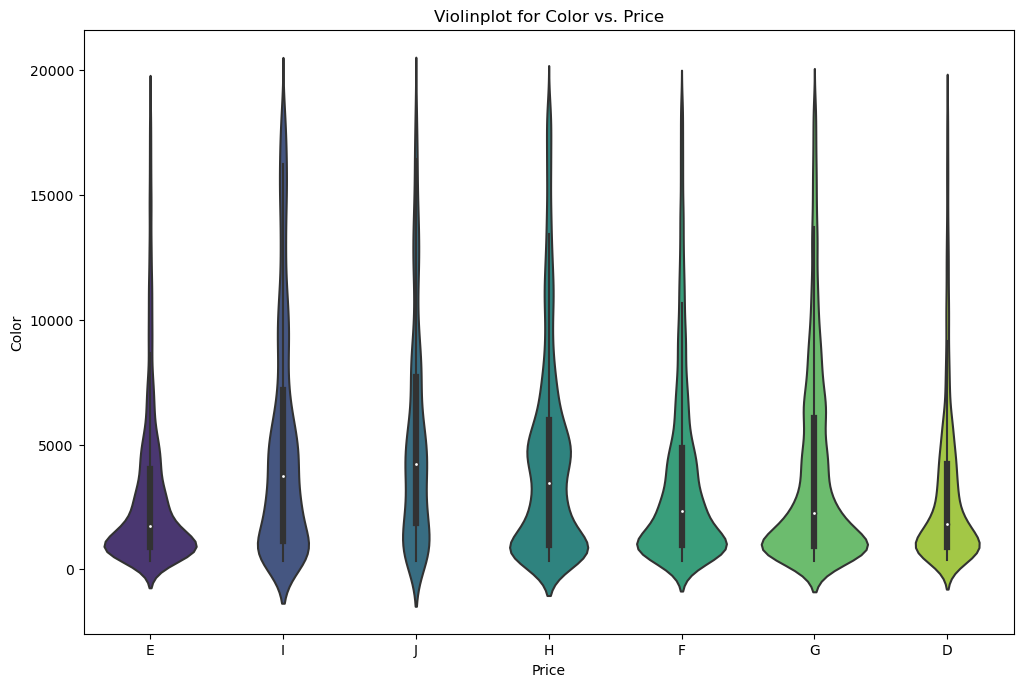

In [103]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(x="color", y="price", data=df, palette="viridis", scale="count")
plt.title("Violinplot for Color vs. Price")
plt.xlabel("Price")
plt.ylabel("Color")

Text(0, 0.5, 'Clarity')

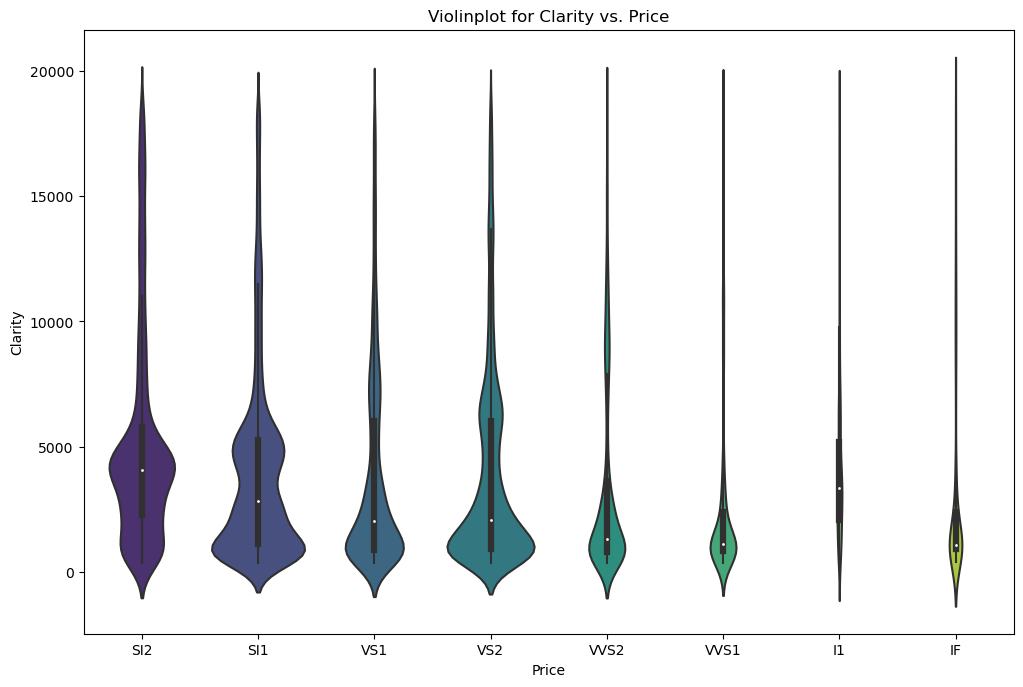

In [104]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(x="clarity", y="price", data=df, palette="viridis", scale="count")
plt.title("Violinplot for Clarity vs. Price")
plt.xlabel("Price")
plt.ylabel("Clarity")

In [161]:

label_data = df.copy()

le = preprocessing.LabelEncoder()

for col in object_col:
    label_data[col] = le.fit_transform(label_data[col])

#export encoder for later use
output = open('model_encoder.pkl', 'wb')
pickle.dump(le, output)
output.close()

In [167]:
label_data[["cut","clarity", "color"]].head(10)

,cut,clarity,color
0,2,3,1
1,3,2,1
2,1,4,1
3,3,5,5
4,1,3,6
5,4,7,6
6,4,6,5
7,4,2,4
8,0,5,1
9,4,4,4


In [125]:
df.describe()

,carat,depth,table,price,x,y,z
count,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000
mean,0.797628,61.749741,57.455948,3930.584470,5.731463,5.733292,3.539441
std,0.473765,1.420119,2.226153,3987.202815,1.119384,1.111252,0.691434
min,0.200000,50.800000,43.000000,326.000000,3.730000,3.680000,2.060000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5322.000000,6.540000,6.540000,4.040000
max,5.010000,73.600000,79.000000,18823.000000,10.740000,10.540000,6.980000


<AxesSubplot:>

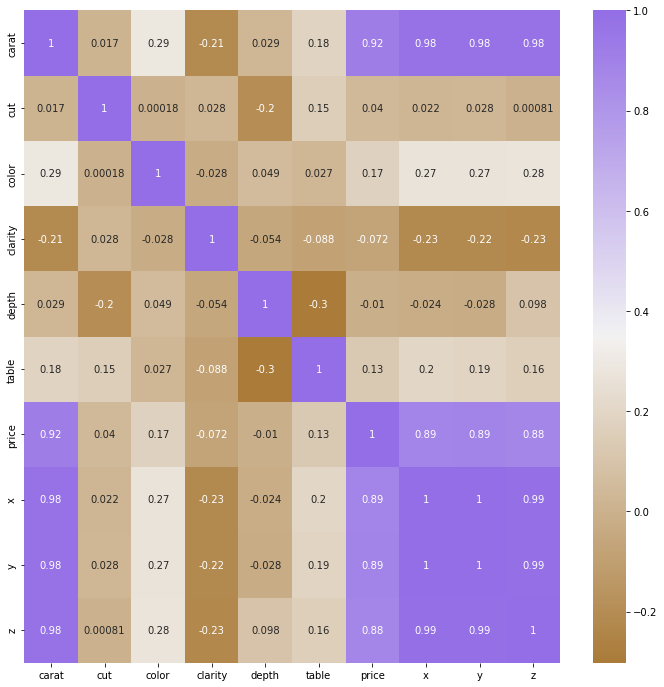

In [126]:
cor_color = sns.diverging_palette(50, 275, s=80, l=55, n=9, as_cmap=True)
corr_data = label_data.corr()

fig, axs = plt.subplots(figsize=(12,12))
sns.heatmap(data=corr_data, cmap=cor_color, annot=True)

## x, y, z has high correlation with Price. 
## On the other hand depth, cut, table has low correlation. Let's work with 2 versions of data to see how they effect models performance:
    1.depth, cut, table preserved
    2.depth, cut, table removed

In [127]:
# 1. depth, cut, table preserved
data_preserved = label_data.copy()
data_preserved.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [129]:
# 2.depth, cut, table removed
data_removed = label_data.drop(label_data[["depth","cut","table"]], axis=1)
data_removed.head()

,carat,color,clarity,price,x,y,z
0,0.23,1,3,326,3.95,3.98,2.43
1,0.21,1,2,326,3.89,3.84,2.31
2,0.23,1,4,327,4.05,4.07,2.31
3,0.29,5,5,334,4.20,4.23,2.63
4,0.31,6,3,335,4.34,4.35,2.75


# Building Models

## Lets start with data_preserved

In [138]:
X = data_preserved.drop(["price"], axis=1)
y = data_preserved["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [142]:
# Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

pipeline_linreg = Pipeline([('scaler1', StandardScaler()), ('lr_classifier', LinearRegression())])

pipeline_dtree = Pipeline([('scaler2', StandardScaler()), ('dt_classifier', DecisionTreeRegressor())])

pipeline_ranfor = Pipeline([('scaler3', StandardScaler()), ('rf_classifier', RandomForestRegressor())])

pipeline_knn = Pipeline([('scaler4', StandardScaler()), ('knn_classifier', KNeighborsRegressor())])

pipeline_xgb = Pipeline([('scaler5', StandardScaler()), ('xgb_classifier', XGBRegressor())])

pipelines = [pipeline_linreg, pipeline_dtree, pipeline_ranfor, pipeline_knn, pipeline_xgb]

pipe = {0:"LinearRegression", 1:"DecisionTree", 2:"RandomForest", 3:"KNeighbors", 4:"XGBoost"}

for val in pipelines:
    val.fit(X_train, y_train)

In [145]:
cv_results = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
    cv_results.append(cv_score)
    print(f"{pipe[i]}: {cv_score.mean()}")

LinearRegression: -1342.6480240349629
DecisionTree: -741.5454988194226
RandomForest: -546.3315861211855
KNeighbors: -827.1644940434446
XGBoost: -545.4999888012928


## It seems like XGB gives the best result.

In [146]:
pred = pipeline_xgb.predict(X_test)

### Evaluate

In [147]:
print("R^2: ", metrics.r2_score(y_test, pred))
print("MAE: ", metrics.mean_absolute_error(y_test, pred))
print("MSE: ", metrics.mean_squared_error(y_test, pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2:  0.980178692198686
MAE:  286.10145386002586
MSE:  316491.9589489481
RMSE:  562.5761805737495


In [157]:
joblib.dump(pipeline_xgb, "data_preserved_model.pkl", compress=3)

['data_preserved_model.pkl']

---

## Second data set with removed columns

In [148]:
data_removed.head()

,carat,color,clarity,price,x,y,z
0,0.23,1,3,326,3.95,3.98,2.43
1,0.21,1,2,326,3.89,3.84,2.31
2,0.23,1,4,327,4.05,4.07,2.31
3,0.29,5,5,334,4.20,4.23,2.63
4,0.31,6,3,335,4.34,4.35,2.75


In [149]:
X = data_removed.drop(["price"], axis=1)
y = data_removed["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [150]:
# Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

pipeline_linreg2 = Pipeline([('scaler1', StandardScaler()), ('lr_classifier', LinearRegression())])

pipeline_dtree2 = Pipeline([('scaler2', StandardScaler()), ('dt_classifier', DecisionTreeRegressor())])

pipeline_ranfor2 = Pipeline([('scaler3', StandardScaler()), ('rf_classifier', RandomForestRegressor())])

pipeline_knn2 = Pipeline([('scaler4', StandardScaler()), ('knn_classifier', KNeighborsRegressor())])

pipeline_xgb2 = Pipeline([('scaler5', StandardScaler()), ('xgb_classifier', XGBRegressor())])

pipelines2 = [pipeline_linreg2, pipeline_dtree2, pipeline_ranfor2, pipeline_knn2, pipeline_xgb2]

pipe2 = {0:"LinearRegression", 1:"DecisionTree", 2:"RandomForest", 3:"KNeighbors", 4:"XGBoost"}

for val in pipelines2:
    val.fit(X_train, y_train)

In [151]:
cv_results2 = []
for i, model in enumerate(pipelines2):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
    cv_results.append(cv_score)
    print(f"{pipe2[i]}: {cv_score.mean()}")

LinearRegression: -1356.0019820125767
DecisionTree: -751.6669786733639
RandomForest: -560.3202551168483
KNeighbors: -577.8839746585344
XGBoost: -555.0246711295852


## It seems like XGB gives the best result on this dataset either.

In [158]:
pred2 = pipeline_xgb2.predict(X_test)
print("R^2: ", metrics.r2_score(y_test, pred2))
print("MAE: ", metrics.mean_absolute_error(y_test, pred2))
print("MSE: ", metrics.mean_squared_error(y_test, pred2))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, pred2)))

R^2:  0.9798326947486963
MAE:  292.2548980118503
MSE:  322016.5899085326
RMSE:  567.4650561122972


In [156]:
joblib.dump(pipeline_xgb2, "data_removed_model.pkl", compress=3)

['data_removed_model.pkl']

---